In [1]:
import os
import numpy as np
import glob
import torch
import torchvision
import torchvision.transforms as transform
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torch.optim import Adam
from torch.autograd import Variable
import pathlib


In [2]:
transformer=transform.Compose([
    transform.Resize((150,150)),
    transform.RandomHorizontalFlip(),
    transform.RandomVerticalFlip(),
    transform.ToTensor(),
    transform.Normalize([0.3,0.3,0.3],
                        [0.9,0.9,0.9])
    
])


In [3]:
train_path='train'

test_path='test'

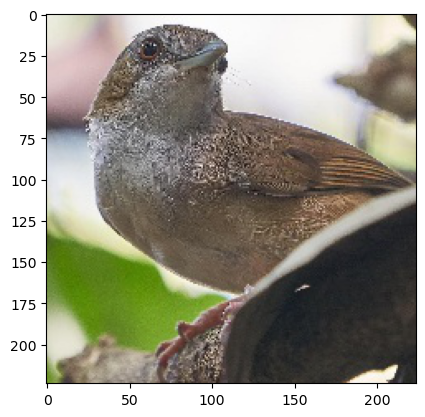

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image
img=Image.open('train/ABBOTTS BABBLER/001.jpg')
plt.imshow(img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


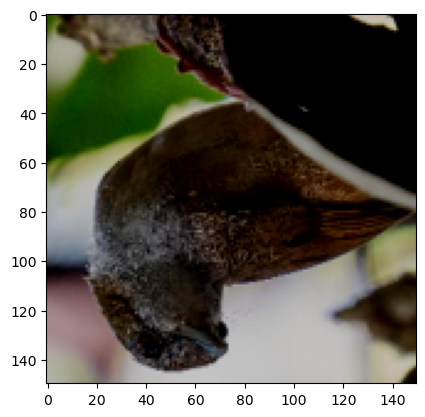

In [5]:
transforms=transform.Compose([transform.ToTensor(),transform.Normalize([0.25,0.25,0.25],[0.25,0.25,0.25])])

img=transformer(img)

plt.imshow(img.permute(1,2,0))

In [6]:
trainloader=DataLoader(
    torchvision.datasets.ImageFolder(train_path,transform=transformer),
    batch_size=32,shuffle=True
)
testloader=DataLoader(
    torchvision.datasets.ImageFolder(test_path,transform=transformer),
    batch_size=32,shuffle=True
)

In [7]:
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])
classes

['ABBOTTS BABBLER',
 'ABBOTTS BOOBY',
 'ABYSSINIAN GROUND HORNBILL',
 'AFRICAN CROWNED CRANE',
 'AFRICAN EMERALD CUCKOO',
 'AFRICAN FIREFINCH',
 'AFRICAN OYSTER CATCHER',
 'AFRICAN PIED HORNBILL',
 'AFRICAN PYGMY GOOSE',
 'ALBATROSS',
 'ALBERTS TOWHEE',
 'ALEXANDRINE PARAKEET',
 'ALPINE CHOUGH',
 'ALTAMIRA YELLOWTHROAT',
 'AMERICAN AVOCET',
 'AMERICAN BITTERN',
 'AMERICAN COOT',
 'AMERICAN DIPPER',
 'AMERICAN FLAMINGO',
 'AMERICAN GOLDFINCH',
 'AMERICAN KESTREL',
 'AMERICAN PIPIT',
 'AMERICAN REDSTART',
 'AMERICAN ROBIN',
 'AMERICAN WIGEON',
 'AMETHYST WOODSTAR',
 'ANDEAN GOOSE',
 'ANDEAN LAPWING',
 'ANDEAN SISKIN',
 'ANHINGA',
 'ANIANIAU',
 'ANNAS HUMMINGBIRD',
 'ANTBIRD',
 'ANTILLEAN EUPHONIA',
 'APAPANE',
 'APOSTLEBIRD',
 'ARARIPE MANAKIN',
 'ASHY STORM PETREL',
 'ASHY THRUSHBIRD',
 'ASIAN CRESTED IBIS',
 'ASIAN DOLLARD BIRD',
 'ASIAN GREEN BEE EATER',
 'ASIAN OPENBILL STORK',
 'AUCKLAND SHAQ',
 'AUSTRAL CANASTERO',
 'AUSTRALASIAN FIGBIRD',
 'AVADAVAT',
 'AZARAS SPINETAIL',
 'AZURE 

In [8]:
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(type(images))
print(images.shape)
print(labels.shape)

<class 'torch.Tensor'>
torch.Size([32, 3, 150, 150])
torch.Size([32])


In [9]:
class ConvNet(nn.Module):
    def __init__(self,num_classes=525):
        super(ConvNet,self).__init__()
        #((w-f+2p)/s)+1
    
        self.conv1=nn.Conv2d(in_channels=3,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.bn1=nn.BatchNorm2d(num_features=64)
        self.relu1=nn.ReLU()
        #shape=(128,64,150,150)
        self.pool=nn.MaxPool2d(kernel_size=2)
        #shape=(128,64,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.relu2=nn.ReLU()
        #shape=(128,32,75,75)
        
        self.conv3=nn.Conv2d(in_channels=32,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.relu3=nn.ReLU()
        #shape=(128,32,75,75)
        #self.pool3=nn.MaxPool2d(kernel_size=2)
        
        
        self.conv4=nn.Conv2d(in_channels=32,out_channels=64,kernel_size=3,stride=1,padding=1)
        self.relu4=nn.ReLU()
        #shape=(128,64,75,75)
        
        self.conv5=nn.Conv2d(in_channels=64,out_channels=32,kernel_size=3,stride=1,padding=1)
        self.bn5=nn.BatchNorm2d(num_features=32)
        self.relu5=nn.ReLU()
        #shape=(128,32,75,75)
        
        
        self.fc=nn.Linear(in_features=32*75*75,out_features=num_classes)
        
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
        
        output=self.pool(output)
        
        output=self.conv2(output)
        output=self.relu2(output)
        
        output=self.conv3(output)
        output=self.relu3(output)
        #output=self.pool3(output)
        
        output=self.conv4(output)
        output=self.relu4(output)
        #output=self.pool4(output)
        
        output=self.conv5(output)
        output=self.bn5(output)
        output=self.relu5(output)
        
        
        output=output.view(-1,32*75*75)
        
        output=self.fc(output)
        
        return output

In [10]:
model=ConvNet(num_classes=525).to('cuda')

In [11]:
optimiser=Adam(model.parameters(),lr=0.01,weight_decay=0.0001)
loss_function=nn.CrossEntropyLoss()

In [12]:
num_epochs=500

In [13]:
train_count=len(glob.glob(train_path+'/**/*.jpg'))
test_count=len(glob.glob(test_path+'/**/*.jpg'))

In [14]:
print(train_count,test_count)

84635 2625


In [ ]:
best_accuracy=0.0

for epoch in range (num_epochs):
    model.train()
    train_accuracy=0.0
    train_loss=0.0
    
    for i ,(images,labels) in enumerate(trainloader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
        optimiser.zero_grad()
        outputs=model(images)
        loss=loss_function(outputs, labels)
        loss.backward()
        optimiser.step()
        
        train_loss+=loss.cpu().data*images.size(0)
        _, prediction=torch.max(outputs.data,1)
        
        train_accuracy+=int(torch.sum(prediction==labels.data))
    train_accuracy=train_accuracy/train_count
    train_loss=train_loss/train_count
    
    
    model.eval()
    test_accuracy=0.0
    
    for i ,(images,labels) in enumerate(testloader):
        if torch.cuda.is_available():
            images=Variable(images.cuda())
            labels=Variable(labels.cuda())
            
            
        outputs=model(images)
        _, prediction=torch.max(outputs.data,1)
        test_accuracy+=int(torch.sum(prediction==labels.data))
        
    test_accuracy=test_accuracy/test_count
    
    if epoch%10==0:
        print('Epoch: '+str(epoch)+' Train loss: '+str(train_loss)+' Train accuracy '+str(train_accuracy)+' Test accuracy '+str(test_accuracy))
    
    if test_accuracy>best_accuracy:
        torch.save(model.state_dict(),'best_checkpoint.model')
        best_accuracy=test_accuracy



Epoch: 0 Train loss: tensor(20.6982) Train accuracy 0.0027884444969575235 Test accuracy 0.0019047619047619048
Epoch: 10 Train loss: tensor(6.2677) Train accuracy 0.00267029006912034 Test accuracy 0.0019047619047619048


In [ ]:
print(torch.cuda.memory_allocated())
#del images,labels,model
torch.cuda.empty_cache()
print(torch.cuda.memory_allocated())
torch.cuda.empty_cache()